In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.preprocessing import LabelBinarizer
import torch
# from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration, WhisperTokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
from mne_bids import BIDSPath
import mne
from scipy.stats import pearsonr, zscore
from functools import partial

/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
base_path = "/srv/nfs-data/sisko"
bids_root = base_path + "/storage/ECoG_podcast/ds005574-1.0.2" 
context_len = 32
subject = '03' # --> 02 e 08 con cura 
ecog_sr = 512
ecog_sr_down = 32
whisper_sr = 16000
tmax = 2.0
pre_stimulus = 2.0
pre_audio = 0.2
func = partial(zscore) 


In [3]:
# model_w = WhisperModel.from_pretrained("openai/whisper-base")
# feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
# tokenizer_w = WhisperTokenizer.from_pretrained("openai/whisper-base")
# processor_w = AutoProcessor.from_pretrained("openai/whisper-base")
# model_w.eval()

from transformers import GPT2TokenizerFast, GPT2Model, AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer_gpt = AutoTokenizer.from_pretrained(model_name)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = AutoModelForCausalLM.from_pretrained(model_name)
model_gpt.eval()
model_gpt.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## From Paper

In [4]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.head(10)

,word,start,end
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111
5,middle.,5.151,5.391
6,So,6.592,6.732
7,there's,6.752,6.912
8,some,6.892,7.052
9,places,7.072,7.342


In [5]:
modelname = "en_core_web_sm"
nlp = spacy.load(modelname)

In [6]:
df.insert(0, "word_idx", df.index.values)
df["word_with_ws"] = df.word.astype(str) + " "
df["hftoken"] = df.word_with_ws.apply(nlp.tokenizer)
df = df.explode("hftoken", ignore_index=True)
df.head(10)

,word_idx,word,start,end,word_with_ws,hftoken
0,0,Act,3.710,3.790,Act,Act
1,1,"one,",3.990,4.190,"one,",one
2,1,"one,",3.990,4.190,"one,",","
3,2,monkey,4.651,4.931,monkey,monkey
4,3,in,4.951,5.011,in,in
5,4,the,5.051,5.111,the,the
6,5,middle.,5.151,5.391,middle.,middle
7,5,middle.,5.151,5.391,middle.,.
8,6,So,6.592,6.732,So,So
9,7,there's,6.752,6.912,there's,there


In [7]:
words = [token.text for token in df.hftoken.tolist()]
spaces = [token.whitespace_ == " " for token in df.hftoken.tolist()]
doc = spacy.tokens.Doc(nlp.vocab, words=words, spaces=spaces)
doc = nlp(doc)

In [8]:
features = []
for token in doc:
    features.append([token.text, token.tag_, token.dep_, token.is_stop])

df2 = pd.DataFrame(
        features, columns=["token", "pos", "dep", "stop"], index=df.index
    )
df = pd.concat([df, df2], axis=1)
df.drop(["hftoken", "word_with_ws"], axis=1, inplace=True)
df.head(10)

,word_idx,word,start,end,token,pos,dep,stop
0,0,Act,3.710,3.790,Act,NNP,ROOT,False
1,1,"one,",3.990,4.190,one,CD,nummod,True
2,1,"one,",3.990,4.190,",",",",punct,False
3,2,monkey,4.651,4.931,monkey,NN,appos,False
4,3,in,4.951,5.011,in,IN,prep,True
5,4,the,5.051,5.111,the,DT,det,True
6,5,middle.,5.151,5.391,middle,NN,pobj,False
7,5,middle.,5.151,5.391,.,.,punct,False
8,6,So,6.592,6.732,So,RB,advmod,True
9,7,there's,6.752,6.912,there,EX,expl,True


In [9]:
taggerEncoder = LabelBinarizer().fit(nlp.get_pipe("tagger").labels)
dependencyEncoder = LabelBinarizer().fit(nlp.get_pipe("parser").labels)

a = taggerEncoder.transform(df.pos.tolist())
b = dependencyEncoder.transform(df.dep.tolist())
c = LabelBinarizer().fit_transform(df.stop.tolist())
embeddings = np.hstack((a, b, c))
print(f"Embeddings have a shape of: {embeddings.shape}")

Embeddings have a shape of: (5305, 96)


### From GPT2

In [10]:
import torch
from accelerate import Accelerator, find_executable_batch_size
from transformers import AutoModelForCausalLM, AutoTokenizer

In [11]:
df = pd.read_csv(transcript_path)

modelname = "gpt2-xl"
context_len = 32
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda", 0)
    print("Using cuda!")

# Load model
tokenizer = AutoTokenizer.from_pretrained(modelname)

df.insert(0, "word_idx", df.index.values)
df["hftoken"] = df.word.apply(lambda x: tokenizer.tokenize(" " + x))

df = df.explode("hftoken", ignore_index=True)
df["token_id"] = df.hftoken.apply(tokenizer.convert_tokens_to_ids)

df.head(10)



Using cuda!


,word_idx,word,start,end,hftoken,token_id
0,0,Act,3.710,3.790,ĠAct,2191
1,1,"one,",3.990,4.190,Ġone,530
2,1,"one,",3.990,4.190,",",11
3,2,monkey,4.651,4.931,Ġmonkey,21657
4,3,in,4.951,5.011,Ġin,287
5,4,the,5.051,5.111,Ġthe,262
6,5,middle.,5.151,5.391,Ġmiddle,3504
7,5,middle.,5.151,5.391,.,13
8,6,So,6.592,6.732,ĠSo,1406
9,7,there's,6.752,6.912,Ġthere,612


In [12]:
model = AutoModelForCausalLM.from_pretrained(modelname)
model = model.eval()
model = model.to(device)

In [13]:
token_ids = df.token_id.tolist()
fill_value = 0
if tokenizer.pad_token_id is not None:
    fill_value = tokenizer.pad_token_id

data = torch.full((len(token_ids), context_len + 1), fill_value, dtype=torch.long)
for i in range(len(token_ids)):
    example_tokens = token_ids[max(0, i - context_len) : i + 1]
    data[i, -len(example_tokens) :] = torch.tensor(example_tokens)

print(f"Data has a shape of: {data.shape}")

Data has a shape of: torch.Size([5491, 33])


In [14]:
import tqdm

accelerator = Accelerator()

@find_executable_batch_size(starting_batch_size=32)
def inference_loop(batch_size=32):
    # nonlocal accelerator  # Ensure they can be used in our context
    accelerator.free_memory()  # Free all lingering references

    data_dl = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=False
        )

    top_guesses = []
    ranks = []
    true_probs = []
    entropies = []
    embeddings = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_dl):
            # Get output from model
            output = model(batch.to(device), output_hidden_states=True)
            logits = output.logits
            states = output.hidden_states

            true_ids = batch[:, -1]
            brange = list(range(len(true_ids)))
            logits_order = logits[:, -2, :].argsort(descending=True)
            batch_top_guesses = logits_order[:, 0]
            batch_ranks = torch.eq(logits_order, true_ids.reshape(-1, 1).to(device)).nonzero()[:, 1]
            batch_probs = torch.softmax(logits[:, -2, :], dim=-1)
            batch_true_probs = batch_probs[brange, true_ids]
            batch_entropy = torch.distributions.Categorical(probs=batch_probs).entropy()
            batch_embeddings = [state[:,-1,:].numpy(force=True) for state in states ]

            top_guesses.append(batch_top_guesses.numpy(force=True))
            ranks.append(batch_ranks.numpy(force=True))
            true_probs.append(batch_true_probs.numpy(force=True))
            entropies.append(batch_entropy.numpy(force=True))
            embeddings.append(batch_embeddings)

        return top_guesses, ranks, true_probs, entropies, embeddings

top_guesses, ranks, true_probs, entropies, embeddings = inference_loop()

100%|██████████| 172/172 [00:21<00:00,  7.99it/s]


In [15]:
df["rank"] = np.concatenate(ranks)
df["true_prob"] = np.concatenate(true_probs)
df["top_pred"] = np.concatenate(top_guesses)
df["entropy"] = np.concatenate(entropies)

df.head(10)

,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402722
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732055
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621271
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444839
5,4,the,5.051,5.111,Ġthe,262,0,0.392203,262,3.781632
6,5,middle.,5.151,5.391,Ġmiddle,3504,0,0.172535,3504,5.194292
7,5,middle.,5.151,5.391,.,13,2,0.142558,0,3.648468
8,6,So,6.592,6.732,ĠSo,1406,70,0.001563,198,5.696713
9,7,there's,6.752,6.912,Ġthere,612,16,0.011315,11,4.845644


In [16]:
print(f"There are {len(embeddings[0])} layers of embeddings")
print(f"Each word embedding is {embeddings[0][0].shape} dimensions long")

There are 49 layers of embeddings
Each word embedding is (32, 1600) dimensions long


In [ ]:
import torch
import numpy as np

all_embeddings = []

for batch_embed in embeddings:  # embeddings[i] = list of 49 tensors, ognuno [batch_size, hidden_dim]
    # Trasforma in tensor [49, batch_size, hidden_dim]
    batch_tensor = torch.stack([torch.tensor(e) for e in batch_embed], dim=0)  # [n_layer, batch_size, hidden]
    batch_tensor = batch_tensor.permute(1, 0, 2)
    all_embeddings.append(batch_tensor)

final_embeddings = torch.cat(all_embeddings, dim=0)
print(final_embeddings.shape)


torch.Size([5491, 49, 1600])


In [123]:
layer_index = -2

all_embeddings = np.concatenate(
    [batch[layer_index] for batch in embeddings],  # ogni elemento ha shape (batch_size, 33, 768)
    axis=0  
)

print(all_embeddings.shape)

(5491, 768)


In [28]:
# transcript_path = f"{bids_root}/stimuli/gpt2-xl/transcript.tsv"
df_contextual = df
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

Model accuracy: 30.942%


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402722
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732055
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621271
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444839


In [ ]:
import numpy as np

n_layers = final_embeddings.shape[1]
hidden_dim = final_embeddings.shape[2]

aligned_embeddings_by_layer = []

for layer in tqdm.tqdm(range(n_layers)):
    layer_emb = final_embeddings[:, layer, :]  # shape: [n_samples, hidden_dim]
    
    aligned_embeddings = []
    for _, group in df_contextual.groupby("word_idx"):  # group by word_idx
        indices = group.index.to_numpy()
        avg_emb = layer_emb[indices].mean(0)  # average over those rows
        aligned_embeddings.append(avg_emb.numpy())  # or keep as tensor

    aligned_embeddings_by_layer.append(np.stack(aligned_embeddings))  # shape: [n_word_idx, hidden_dim]

final_aligned = np.stack(aligned_embeddings_by_layer, axis=1)  # [n_word_idx, 49, hidden_dim]
print(f"Aligned embeddings shape: {final_aligned.shape}")


Aligned embeddings shape: (5136, 49, 1600)


In [125]:
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = all_embeddings[indices].mean(0) # average features
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 768)


In [126]:
df_word = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


In [127]:
df_word.to_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv", index=False)
torch.save(torch.tensor(aligned_embeddings), "/srv/nfs-data/sisko/matteoc/podcast/text_embeds_gpt_eleven.pt")

## Start from Here

In [ ]:
# from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoFeatureExtractor, AutoProcessor, WhisperTokenizer
# import torchaudio

# model_name = "openai/whisper-base"

# model_w = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# tokenizer_w = WhisperTokenizer.from_pretrained(model_name)
# processor_w = AutoProcessor.from_pretrained(model_name)
# model_w.eval()
# model_w.to(device)

In [5]:
from utils import preprocess_raw_audio
from scipy.io import wavfile

file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     suffix="ieeg",
                     extension="fif")


transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
events = np.zeros((len(df), 3))
events[:, 0] = df.start

audio_path = f"{bids_root}/stimuli/podcast.wav"
audio_sf, audio_wave = wavfile.read(audio_path)
audio_wave_clean = preprocess_raw_audio(audio_wave, audio_sf)

/tmp/ipykernel_2098456/1920131353.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [6]:
from torch.nn.utils.rnn import pad_sequence
import tqdm

download_text = False

def get_text_and_brain(file_path, df, tmax=2.0, pre_audio=2.0, pre_stimulus=2.0,
                          model=None, tokenizer=None,
                          device=device, context_len=32):
    
    model = model.to(device)

    raw = mne.io.read_raw_fif(file_path, verbose=False)
    raw = raw.pick("ecog", exclude="bads")
    raw.load_data()
    raw = raw.apply_function(func, channel_wise=True, verbose=False)

    # events = np.zeros((len(df), 3), dtype=int)
    # events[:, 0] = (df.start * raw.info['sfreq']).astype(int)
    df.dropna(subset=['start'], inplace=True)
    df.sort_values("start", inplace=True)
    events = np.zeros((len(df), 3))
    events[:, 0] = df.start

    epochs = mne.Epochs(
        raw,
        (events * raw.info['sfreq']).astype(int),
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")
    
    attention_mask_list = []
    if download_text:
        text_decoder_embd = []
        embedd_eleven = []
        embedd_ten = []
        embedd_nine = []
        embedd_eight = []
        embedd_seven = []
        embedd_six = []
        embedd_fifth = []
        embedd_four = []
        embedd_third = []
        embedd_second = []

        for row_idx in tqdm.tqdm(good_idx):
            
            row = df.iloc[row_idx]
            word_list = df[
                (df["start"] >= row["start"] - pre_audio) & 
                (df["start"] <= row["start"])
            ]
            words_in_segment = word_list["word"].tolist()
            transcription = " ".join(words_in_segment)

            # row = df.iloc[row_idx]
            # current_idx = row.name  
            # start_idx = max(0, current_idx - context_len)
            # end_idx = min(len(df), current_idx + 1)  
            # words_in_context = df.iloc[start_idx:end_idx]["word"].tolist()
            # transcription_context = " ".join(words_in_context)

            with torch.no_grad():    
                # -------- GPT
                inputs = tokenizer(
                    transcription, 
                    return_tensors="pt"
                )
                input_ids = inputs["input_ids"].to(device)
                attention_mask = inputs["attention_mask"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
                last_hidden_dec = outputs.hidden_states[-1].squeeze(0)
                eleven_hidden = outputs.hidden_states[-2].squeeze(0)
                ten_hidden = outputs.hidden_states[-3].squeeze(0)
                nine_hidden = outputs.hidden_states[-4].squeeze(0)
                eight_hidden = outputs.hidden_states[-5].squeeze(0)
                seven_hidden = outputs.hidden_states[-6].squeeze(0)
                six_hidden = outputs.hidden_states[-7].squeeze(0)
                fifth_hidden = outputs.hidden_states[-8].squeeze(0)
                four_hidden = outputs.hidden_states[-9].squeeze(0)
                third_hidden = outputs.hidden_states[-10].squeeze(0)
                second_hidden = outputs.hidden_states[-11].squeeze(0)
                attention_mask = attention_mask.squeeze(0)
                text_decoder_embd.append(last_hidden_dec.cpu())
                attention_mask_list.append(attention_mask.cpu())
                embedd_eleven.append(eleven_hidden.cpu())
                embedd_ten.append(ten_hidden.cpu())
                embedd_nine.append(nine_hidden.cpu())
                embedd_eight.append(eight_hidden.cpu())
                embedd_seven.append(seven_hidden.cpu())
                embedd_six.append(six_hidden.cpu())
                embedd_fifth.append(fifth_hidden.cpu())
                embedd_four.append(four_hidden.cpu())
                embedd_third.append(third_hidden.cpu())
                embedd_second.append(second_hidden.cpu())

        
        text_decoder_embd = pad_sequence(text_decoder_embd, batch_first=True, padding_side='left')   
        embedd_eleven = pad_sequence(embedd_eleven, batch_first=True, padding_side='left')
        embedd_ten = pad_sequence(embedd_ten, batch_first=True, padding_side='left')
        embedd_nine = pad_sequence(embedd_nine, batch_first=True, padding_side='left')
        embedd_eight = pad_sequence(embedd_eight, batch_first=True, padding_side='left')
        embedd_seven = pad_sequence(embedd_seven, batch_first=True, padding_side='left')
        embedd_six = pad_sequence(embedd_six, batch_first=True, padding_side='left')
        embedd_fifth = pad_sequence(embedd_fifth, batch_first=True, padding_side='left')
        embedd_four = pad_sequence(embedd_four, batch_first=True, padding_side='left')
        embedd_third = pad_sequence(embedd_third, batch_first=True, padding_side='left')
        embedd_second = pad_sequence(embedd_second, batch_first=True, padding_side='left')
        # text_decoder_embd = torch.stack(text_decoder_embd, dim=0) 
        attention_mask_list = pad_sequence(attention_mask_list, batch_first=True, padding_side='left')  
        # torch.save(text_decoder_embd, f"{base_path}/matteoc/podcast/text_2_2_sec_last.pt")
        # torch.save(embedd_eleven, f"{base_path}/matteoc/podcast/text_2_2_sec_eleven.pt")
        # torch.save(embedd_ten, f"{base_path}/matteoc/podcast/text_2_2_sec_ten.pt")
        # torch.save(embedd_nine, f"{base_path}/matteoc/podcast/text_2_2_sec_nine.pt")
        # torch.save(embedd_eight, f"{base_path}/matteoc/podcast/text_2_2_sec_eight.pt")
        # torch.save(embedd_seven, f"{base_path}/matteoc/podcast/text_2_2_sec_seven.pt")
        # torch.save(embedd_six, f"{base_path}/matteoc/podcast/text_2_2_sec_six.pt")
        torch.save(embedd_fifth, f"{base_path}/matteoc/podcast/text_2_2_sec_fifth.pt")
        torch.save(embedd_four, f"{base_path}/matteoc/podcast/text_2_2_sec_four.pt")
        torch.save(embedd_third, f"{base_path}/matteoc/podcast/text_2_2_sec_third.pt")
        torch.save(embedd_second, f"{base_path}/matteoc/podcast/text_2_2_sec_second.pt")

    else:
        text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_2_2_sec_last.pt")

    print(f"Text snippets after processing have a shape of: {text_decoder_embd.shape}")

    return epochs_snippet, text_decoder_embd, attention_mask_list, good_idx

In [ ]:
# from torch.nn.utils.rnn import pad_sequence
# import tqdm

# download_text = True

# def get_text_and_brain_w(file_path, df, tmax=2.0, pre_audio=2.0, pre_stimulus=2.0,
#                           model=None, tokenizer=None, processor=None,
#                           device=device, context_len=32):
    
#     model = model.to(device)

#     raw = mne.io.read_raw_fif(file_path, verbose=False)
#     raw.load_data()
#     raw = raw.apply_function(func, channel_wise=True, verbose=False)

#     # events = np.zeros((len(df), 3), dtype=int)
#     # events[:, 0] = (df.start * raw.info['sfreq']).astype(int)
#     df.dropna(subset=['start'], inplace=True)
#     df.sort_values("start", inplace=True)
#     events = np.zeros((len(df), 3))
#     events[:, 0] = df.start

#     epochs = mne.Epochs(
#         raw,
#         (events * raw.info['sfreq']).astype(int),
#         tmin=-pre_stimulus,
#         tmax=tmax,
#         baseline=None,
#         proj=False,
#         event_id=None,
#         preload=True,
#         event_repeated="merge",
#         verbose=False
#     )
#     good_idx = epochs.selection
#     print(f"Epochs object has a shape of: {epochs._data.shape}")
#     epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
#     epochs_snippet = epochs._data
#     print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

#     if download_text:
#         text_decoder_embd = []

#         for idx, row in tqdm.tqdm(enumerate(good_idx)):
#             row = df.iloc[idx]
#             start_sample = int((row['start']) * audio_sf) 
#             end_sample = start_sample + int(tmax * audio_sf)
#             snippet = audio_wave_clean[start_sample - int(pre_audio * audio_sf):end_sample]
#             if len(snippet) < int(tmax * audio_sf):
#                 padding_len = int(tmax * audio_sf) - len(snippet)
#                 snippet = np.pad(snippet, (0, padding_len), mode='constant')
#             snippet = torchaudio.transforms.Resample(audio_sf, whisper_sr)(torch.tensor(snippet).float())
#             inputs = processor(snippet.squeeze(0), sampling_rate=whisper_sr, return_tensors="pt")
#             input_features = inputs['input_features'].to(device)
#             with torch.no_grad():
#                 encoder_outputs = model.model.encoder(input_features=input_features, output_hidden_states=True)
            
#                 word_list = df[
#                     (df["start"] >= row["start"] - pre_audio) & 
#                     (df["end"] <= row["start"] + tmax)
#                 ]
#                 words_in_segment = word_list["word"].tolist()
#                 transcription = " ".join(words_in_segment)
#                 decoder_inputs = tokenizer(transcription, return_tensors="pt").input_ids.to(device)
#                 outputs = model.model.decoder(
#                     input_ids=decoder_inputs,
#                     encoder_hidden_states=encoder_outputs.last_hidden_state.to(device),
#                     output_hidden_states=True,
#                     return_dict=True
#                 )
#                 decoder_hidden_states = outputs.hidden_states[-1]
#                 text_decoder_embd.append(decoder_hidden_states.squeeze(0))
        
#         text_decoder_embd = pad_sequence(text_decoder_embd, batch_first=True, padding_side='left')   
#         # text_decoder_embd = torch.stack(text_decoder_embd, dim=0) 
#         # torch.save(text_decoder_embd, f"{base_path}/matteoc/podcast/text_2_2_sec.pt")

#     else:
#         text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_token_embeds_gpt.pt")
#         text_decoder_embd = text_decoder_embd[good_idx]

#     print(f"Text snippets after processing have a shape of: {text_decoder_embd.shape}")

#     return epochs_snippet, text_decoder_embd

In [7]:
df_word = pd.read_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv")
brain_data, text_decoder_embd, attention_mask_list, good_idx = get_text_and_brain(file_path, df=df, tmax=tmax, model=model_gpt,
                                                      tokenizer=tokenizer_gpt, pre_stimulus=pre_stimulus, 
                                                      pre_audio=pre_audio)
# text_decoder_embd = text_decoder_embd[good_idx]
# X_padded = F.pad(text_decoder_embd, (0, 0, 23, 0))
# X_windowed = X_padded.unfold(dimension=0, size=24, step=1)
# X_windowed = X_windowed.permute(0,2,1)


Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Epochs object has a shape of: (5130, 235, 2049)
Epochs object after down-sampling has a shape of: (5130, 235, 128)


/tmp/ipykernel_2098456/114609266.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_decoder_embd = torch.load(f"{base_path}/matteoc/podcast/text_2_2_sec_last.pt")


Text snippets after processing have a shape of: torch.Size([5130, 21, 768])


In [8]:
brain_data.mean(), brain_data.std(), text_decoder_embd.mean(), text_decoder_embd.std()

(0.0008530822839909778, 0.9270900334094264, tensor(0.1162), tensor(4.7537))

In [ ]:
def repeat_with_noise(x, repeats=6, noise_std=0.1):
    
    batch_size, time_in, dim = x.shape
    x_rep = x.repeat_interleave(repeats=repeats, dim=1)  # (batch, time_in * repeats, dim)
    mask = torch.zeros_like(x_rep, dtype=torch.bool)
    for i in tqdm(range(time_in)):
        mask[:, i * repeats] = True 
    noise = torch.randn_like(x_rep) * noise_std
    x_rep = torch.where(mask, x_rep, x_rep + noise)

    return x_rep  # (batch, time_in * repeats, dim)


def repeat_with_noise_end(x, repeats=6, noise_std=0.1):
    batch_size, time_in, dim = x.shape

    x_rep = x.repeat_interleave(repeats - 1, dim=1)  # (batch, time_in * (repeats-1), dim)
    noise = torch.randn_like(x_rep) * noise_std
    x_rep_noisy = x_rep + noise

    x_final = torch.cat([x_rep_noisy, x], dim=1)  # (batch, time_in * (repeats-1) + time_in, dim)

    return x_final


text_decoder_embd_augm = repeat_with_noise_end(text_decoder_embd)

print(text_decoder_embd_augm.shape)

In [9]:
brain_timep = brain_data.shape[-1]
brain_channels = brain_data.shape[1]
audio_timep = text_decoder_embd.shape[1]
text_feature = text_decoder_embd.shape[-1]

In [21]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torch

n = brain_data.shape[0]
train_size = int(0.5 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

indices = list(range(n))
train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

brain_train_std = torch.tensor(brain_data[train_idx], dtype=torch.float32)
brain_val_std   = torch.tensor(brain_data[val_idx],   dtype=torch.float32)
brain_test_std  = torch.tensor(brain_data[test_idx],  dtype=torch.float32)

stimuli = torch.tensor(text_decoder_embd).to(torch.float32)
stimuli_train = stimuli[train_idx]
stimuli_val   = stimuli[val_idx]
stimuli_test  = stimuli[test_idx]

# attention_masks = torch.tensor(attention_masks).to(torch.float32)
# if attention_masks is not None:
#     attention_masks_train = attention_masks[train_idx]
#     attention_masks_val   = attention_masks[val_idx]
#     attention_masks_test  = attention_masks[test_idx]

train_ds = TensorDataset(stimuli_train, brain_train_std)
val_ds   = TensorDataset(stimuli_val, brain_val_std)
test_ds  = TensorDataset(stimuli_test, brain_test_std)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_1986231/819218728.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stimuli = torch.tensor(text_decoder_embd).to(torch.float32)


In [22]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # se usi GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
from torch import nn, optim
from tqdm import tqdm
from models import AttentiveStim2BrainNet, LearnableTau, SoftMappingGRUSeq, Audio2BrainCNN
import torch.nn.functional as F

set_seed(42)
# model = SoftMappingGRUSeq(input_dim=text_feature, hidden_dim=128, time_out=brain_timep, output_channels=brain_channels).to(device)
model = AttentiveStim2BrainNet(input_dim=text_feature, output_channels=brain_channels, time_in=audio_timep, time_out=brain_timep, d_model=256, nhead=4, num_layers=2).to(device)   # 256

mse_loss = nn.MSELoss()
tau_module = LearnableTau(init_tau=0.03).to(device) # 0.03

mse_perc = 0.0
cl_perc = 1.0

def pearson_loss(pred, target, eps=1e-8):
    pred = pred - pred.mean(dim=-1, keepdim=True)
    target = target - target.mean(dim=-1, keepdim=True)
    corr_num = (pred * target).sum(dim=-1)
    corr_den = (pred.norm(dim=-1) * target.norm(dim=-1)).clamp(min=eps)
    corr = corr_num / corr_den
    return 1 - corr.mean()

def contrastive_loss(pred, target, tau=0.03):
    target = target.reshape(target.shape[0], -1)
    pred = pred.reshape(pred.shape[0], -1)   
    pred = F.normalize(pred, dim=1)   # (batch, 1)
    target = F.normalize(target, dim=1)
    sim_matrix = torch.mm(pred, target.T)   # (batch, batch)
    sim_matrix = sim_matrix / tau
    loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
    return loss.mean()

# def contrastive_loss_batch(pred, target, tau=0.05):
#     pred = F.normalize(pred.reshape(pred.shape[0], -1), dim=1)
#     target = F.normalize(target.reshape(target.shape[0], -1), dim=1)
#     sim_matrix = torch.mm(pred, target.T)  # (batch, batch)
#     logits = sim_matrix / tau
#     labels = torch.arange(pred.size(0)).to(pred.device)
#     loss = F.cross_entropy(logits, labels)
#     return loss


optimizer = optim.AdamW(list(model.parameters()) + list(tau_module.parameters()), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)   # 1e-4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training loop
num_epochs = 35
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred, _ = model(x)
        loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
            val_loss += loss.item() * x.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Salva il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/home/matteoc/ecog-speech/best_model_CL2.pt")


Epoch 1/35: 100%|██████████| 81/81 [00:01<00:00, 75.65it/s]


Epoch 1, Train Loss: 3.5465, Val Loss: 3.5120


Epoch 2/35: 100%|██████████| 81/81 [00:01<00:00, 79.53it/s]


Epoch 2, Train Loss: 3.4961, Val Loss: 3.4850


Epoch 3/35: 100%|██████████| 81/81 [00:00<00:00, 81.84it/s]


Epoch 3, Train Loss: 3.4759, Val Loss: 3.4875


Epoch 4/35: 100%|██████████| 81/81 [00:00<00:00, 82.29it/s]


Epoch 4, Train Loss: 3.4577, Val Loss: 3.4513


Epoch 5/35: 100%|██████████| 81/81 [00:01<00:00, 80.51it/s]


Epoch 5, Train Loss: 3.4265, Val Loss: 3.4488


Epoch 6/35: 100%|██████████| 81/81 [00:01<00:00, 77.60it/s]


Epoch 6, Train Loss: 3.3976, Val Loss: 3.4135


Epoch 7/35: 100%|██████████| 81/81 [00:01<00:00, 77.46it/s]


Epoch 7, Train Loss: 3.3665, Val Loss: 3.3902


Epoch 8/35: 100%|██████████| 81/81 [00:00<00:00, 95.90it/s] 


Epoch 8, Train Loss: 3.3073, Val Loss: 3.3754


Epoch 9/35: 100%|██████████| 81/81 [00:00<00:00, 100.06it/s]


Epoch 9, Train Loss: 3.2370, Val Loss: 3.3707


Epoch 10/35: 100%|██████████| 81/81 [00:00<00:00, 99.73it/s]


Epoch 10, Train Loss: 3.1501, Val Loss: 3.3584


Epoch 11/35: 100%|██████████| 81/81 [00:00<00:00, 91.84it/s] 


Epoch 11, Train Loss: 3.0344, Val Loss: 3.3547


Epoch 12/35: 100%|██████████| 81/81 [00:00<00:00, 96.29it/s] 


Epoch 12, Train Loss: 2.9206, Val Loss: 3.4068


Epoch 13/35: 100%|██████████| 81/81 [00:01<00:00, 80.08it/s]


Epoch 13, Train Loss: 2.8925, Val Loss: 3.4580


Epoch 14/35: 100%|██████████| 81/81 [00:01<00:00, 80.02it/s]


Epoch 14, Train Loss: 2.8347, Val Loss: 3.4190


Epoch 15/35: 100%|██████████| 81/81 [00:00<00:00, 82.11it/s]


Epoch 15, Train Loss: 2.7002, Val Loss: 3.4241


Epoch 16/35: 100%|██████████| 81/81 [00:01<00:00, 80.23it/s]


Epoch 16, Train Loss: 2.5274, Val Loss: 3.4421


Epoch 17/35: 100%|██████████| 81/81 [00:01<00:00, 79.90it/s]


Epoch 17, Train Loss: 2.4553, Val Loss: 3.4904


Epoch 18/35: 100%|██████████| 81/81 [00:00<00:00, 83.24it/s]


Epoch 18, Train Loss: 2.3381, Val Loss: 3.4396


Epoch 19/35: 100%|██████████| 81/81 [00:01<00:00, 79.89it/s]


Epoch 19, Train Loss: 2.2632, Val Loss: 3.4520


Epoch 20/35: 100%|██████████| 81/81 [00:01<00:00, 80.52it/s]


Epoch 20, Train Loss: 2.2406, Val Loss: 3.4597


Epoch 21/35: 100%|██████████| 81/81 [00:00<00:00, 84.07it/s]


Epoch 21, Train Loss: 2.2122, Val Loss: 3.4653


Epoch 22/35: 100%|██████████| 81/81 [00:00<00:00, 86.73it/s] 


Epoch 22, Train Loss: 2.1907, Val Loss: 3.4748


Epoch 23/35: 100%|██████████| 81/81 [00:01<00:00, 79.08it/s]


Epoch 23, Train Loss: 2.1722, Val Loss: 3.4829


Epoch 24/35: 100%|██████████| 81/81 [00:01<00:00, 79.09it/s]


Epoch 24, Train Loss: 2.1359, Val Loss: 3.4583


Epoch 25/35: 100%|██████████| 81/81 [00:01<00:00, 80.47it/s]


Epoch 25, Train Loss: 2.1238, Val Loss: 3.4574


Epoch 26/35: 100%|██████████| 81/81 [00:01<00:00, 78.99it/s]


Epoch 26, Train Loss: 2.1221, Val Loss: 3.4579


Epoch 27/35: 100%|██████████| 81/81 [00:01<00:00, 77.62it/s]


Epoch 27, Train Loss: 2.1134, Val Loss: 3.4589


Epoch 28/35: 100%|██████████| 81/81 [00:01<00:00, 79.65it/s]


Epoch 28, Train Loss: 2.1160, Val Loss: 3.4604


Epoch 29/35: 100%|██████████| 81/81 [00:01<00:00, 79.99it/s]


Epoch 29, Train Loss: 2.1090, Val Loss: 3.4611


Epoch 30/35: 100%|██████████| 81/81 [00:01<00:00, 77.67it/s]


Epoch 30, Train Loss: 2.1069, Val Loss: 3.4614


Epoch 31/35: 100%|██████████| 81/81 [00:00<00:00, 82.93it/s]


Epoch 31, Train Loss: 2.1038, Val Loss: 3.4615


Epoch 32/35: 100%|██████████| 81/81 [00:01<00:00, 75.69it/s]


Epoch 32, Train Loss: 2.1051, Val Loss: 3.4615


Epoch 33/35: 100%|██████████| 81/81 [00:01<00:00, 75.12it/s]


Epoch 33, Train Loss: 2.1046, Val Loss: 3.4617


Epoch 34/35: 100%|██████████| 81/81 [00:01<00:00, 78.04it/s]


Epoch 34, Train Loss: 2.1034, Val Loss: 3.4618


Epoch 35/35: 100%|██████████| 81/81 [00:01<00:00, 79.54it/s]

Epoch 35, Train Loss: 2.1031, Val Loss: 3.4619


In [24]:
# Valutazione finale su test set
model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))
model.eval()
test_loss = 0
y_pred_all = []
y_true_all = []
attn_pred_all = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred, attn_pred = model(x)
        attn_pred_all.append(attn_pred.cpu())
        y_pred_all.append(y_pred)
        y_true_all.append(y.cpu())
        test_loss += (mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())) * x.size(0)
y_pred_all = torch.cat(y_pred_all, dim=0)
y_true_all = torch.cat(y_true_all, dim=0)
attn_pred_all = torch.cat(attn_pred_all, dim=0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

/tmp/ipykernel_1986231/3312210815.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))


Test Loss: 3.5548


<Axes: >

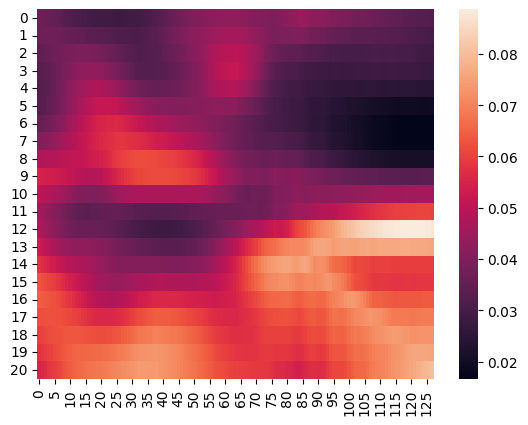

In [25]:
import seaborn as sns

sns.heatmap(attn_pred_all.mean(dim=0).T.cpu().numpy(), cbar=True)

## Cross Valid

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from models import AttentiveStim2BrainNet, LearnableTau, SoftMappingGRUSeq

outer_cv = KFold(n_splits=4, shuffle=False)
all_corrs, all_attn = [], []

brain_np = brain_data.reshape(brain_data.shape[0], -1)
# audio_np = audio_data.cpu().numpy()

for fold_idx, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(brain_data))):
    print(f"\n--- Fold {fold_idx + 1} ---")

    scaler = StandardScaler()
    brain_train = scaler.fit_transform(brain_np[train_idx])
    brain_test = scaler.transform(brain_np[test_idx])

    brain_train = torch.tensor(brain_train, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)
    brain_test = torch.tensor(brain_test, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)

    stimuli_train = text_decoder_embd[train_idx]
    stimuli_test = text_decoder_embd[test_idx]

    train_dataset = TensorDataset(stimuli_train.to(device), brain_train.to(device))
    test_dataset = TensorDataset(stimuli_test.to(device), brain_test.to(device))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    set_seed(42)
    model = AttentiveStim2BrainNet(           
        input_dim=text_feature, d_model=256, nhead=2, num_layers=2,
        time_in=audio_timep, time_out=brain_timep,
        output_channels=brain_channels
    ).to(device)
    # model = SoftMappingGRUSeq(input_dim=512, hidden_dim=128, time_out=brain_timep, output_channels=brain_channels).to(device)   # 128 o 64
    tau_module = LearnableTau(init_tau=0.03).to(device)
    mse_loss = nn.MSELoss()
    mse_perc = 0.0
    cl_perc = 1.0

    def contrastive_loss(pred, target, tau=0.05):
        target = target.reshape(target.shape[0], -1)
        pred = pred.reshape(pred.shape[0], -1)
        pred = F.normalize(pred, dim=1)
        target = F.normalize(target, dim=1)
        sim_matrix = torch.mm(pred, target.T) / tau
        loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
        return loss.mean()

    optimizer = optim.AdamW(list(model.parameters()) + list(tau_module.parameters()), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)   # 1e-4
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

    best_loss = float('inf')
    for epoch in range(30):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y  = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        total_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred, _ = model(x)
                loss = mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y, tau=tau_module())
                val_loss += loss.item() * x.size(0)
        val_loss /= len(test_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {total_loss:.4f} | Test Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt")

    # Valutazione finale (ad es. Pearson corr)
    model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt"))
    model.eval()
    preds, targets, attn_values = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            y, x = y.to(device), x.to(device)
            y_pred, attn_pred = model(x)
            preds.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())
            attn_values.append(attn_pred.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)
    attn_values = np.concatenate(attn_values, axis=0)

    # corrs = np.array([np.corrcoef(p, t)[0, 1] for p, t in zip(preds.T, targets.T)]).reshape(brain_channels, brain_timep)
    corrs = np.zeros((brain_channels, brain_timep))
    for ch in range(brain_channels):
        for t in range(brain_timep):
            corrs[ch, t] = np.corrcoef(preds[:, ch, t], targets[:, ch, t])[0, 1]
    all_corrs.append(corrs)
    all_attn.append(attn_values)

# Risultati finali
all_corrs = np.stack(all_corrs)
all_attn = np.concatenate(all_attn, axis=0)
print(f"\nFinal mean correlation across folds: {all_corrs.mean():.4f}")


In [ ]:
import seaborn as sns

print(all_attn.shape)
print(all_corrs.shape)

sns.heatmap(all_attn.mean(axis=0).T, cbar=True)

In [ ]:
from matplotlib import pyplot as plt

lags = np.linspace(-pre_stimulus, tmax, brain_timep) 
mean = all_corrs.mean((0, 1))
# std = correlations_time.std((0)) 
std = all_corrs.std((0, 1)) / np.sqrt(np.product(all_corrs.shape[:2]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

In [ ]:
from nilearn.plotting import plot_markers

raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = all_corrs.mean((0,2)).argsort()
plot_markers(all_corrs.mean((0,2))[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

## Evaluation

In [26]:
from torchmetrics.functional import pearson_corrcoef

correlations_time = np.zeros((y_pred_all.shape[0], y_pred_all.shape[2]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for tp in range(y_pred_all.shape[2]):
        pred = y_pred_sample[:, tp]
        target = y_true_sample[:, tp]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_time[sample, tp] = corr.item()

100%|██████████| 2052/2052 [00:31<00:00, 65.03it/s]


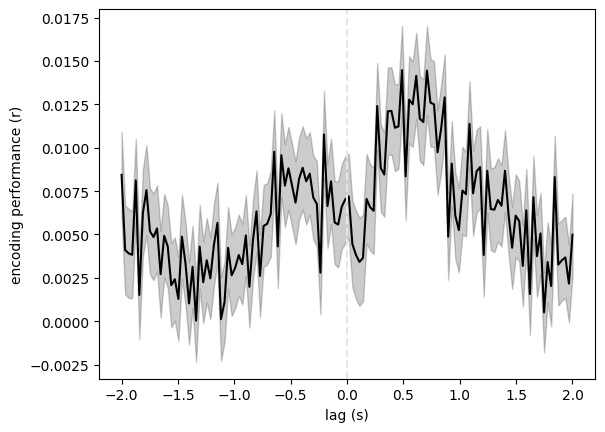

In [27]:
from matplotlib import pyplot as plt

n_array = 100

lags = np.linspace(-pre_stimulus, tmax, brain_timep) 
# value_array = y_pred_all[:,n_array,:].mean((0))
mean = correlations_time.mean((0))
std = correlations_time.std((0)) / np.sqrt(np.product(correlations_time.shape[:1]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

In [28]:
from torchmetrics.functional import pearson_corrcoef

correlations_channels = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for channel in range(y_pred_all.shape[1]):
        pred = y_pred_sample[channel, :]
        target = y_true_sample[channel, :]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_channels[sample, channel] = corr.item()

100%|██████████| 2052/2052 [00:18<00:00, 111.94it/s]


In [29]:
correlations_channels_mean = np.nanmean(correlations_channels, axis=0)

Coordinate matrix shape:  (90, 3)


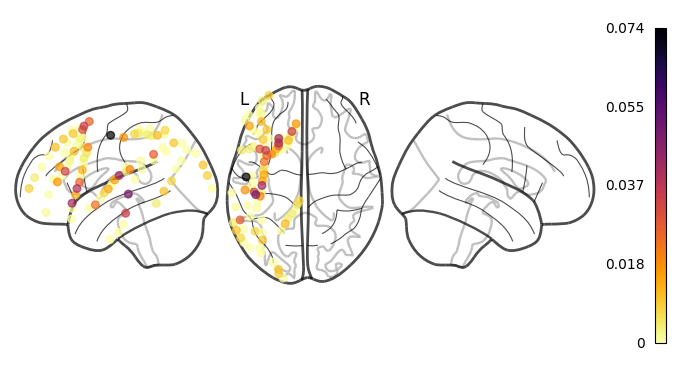

In [30]:
from nilearn.plotting import plot_markers

raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = correlations_channels_mean.argsort()
plot_markers(correlations_channels_mean[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

## Permutations

In [31]:
def batch_pearson_corr(x, y):
    """ x, y: tensors of shape (n_samples, n_features) """
    x_centered = x - x.mean(dim=1, keepdim=True)
    y_centered = y - y.mean(dim=1, keepdim=True)
    numerator = (x_centered * y_centered).sum(dim=1)
    denominator = torch.sqrt((x_centered**2).sum(dim=1) * (y_centered**2).sum(dim=1))
    return numerator / (denominator + 1e-8)  # aggiunta eps per stabilità numerica


n_permutations = 500
n_samples, n_channels, n_timepoints = y_pred_all.shape
device = 6
null_distribution_tp = np.zeros((n_permutations, n_timepoints))
null_distribution_ch = np.zeros((n_permutations, n_channels))

for perm in tqdm(range(n_permutations), desc="Permutation runs"):
    shuffled_idx = np.random.permutation(n_samples)
    y_true_perm = y_true_all[shuffled_idx]

    for tp in range(n_timepoints):
        pred_tp = torch.tensor(y_pred_all[:, :, tp])  # (samples, voxels)
        true_tp = torch.tensor(y_true_perm[:, :, tp]).to(device)  
        corrs = batch_pearson_corr(pred_tp, true_tp)  # (samples,)
        null_distribution_tp[perm, tp] = corrs.mean().item()

    for ch in range(n_channels):
        pred_ch = torch.tensor(y_pred_all[:, ch, :])  
        true_ch = torch.tensor(y_true_perm[:, ch, :]).to(device)  
        corrs_ch = batch_pearson_corr(pred_ch, true_ch)  
        null_distribution_ch[perm, ch] = corrs_ch.mean().item()

Permutation runs:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_1986231/567332162.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_tp = torch.tensor(y_pred_all[:, :, tp])  # (samples, voxels)
/tmp/ipykernel_1986231/567332162.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_tp = torch.tensor(y_true_perm[:, :, tp]).to(device)
/tmp/ipykernel_1986231/567332162.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_ch = torch.tensor(y_pred_all[:, ch, :])
/tmp/ipykernel_1986231/567332162.py:28: UserWarning: To copy 

In [32]:
real_corr_tp = correlations_time.mean(axis=0)
real_corr_ch = correlations_channels.mean(axis=0)
p_values_tp = np.mean(null_distribution_tp >= real_corr_tp[None, :], axis=0)  
p_values_ch = np.mean(null_distribution_ch >= real_corr_ch[None, :], axis=0)  

In [33]:
from statsmodels.stats.multitest import fdrcorrection

significant_tp, pvals_corrected_tp = fdrcorrection(p_values_tp, alpha=0.01)
significant_ch, pvals_corrected_ch = fdrcorrection(p_values_ch, alpha=0.01)

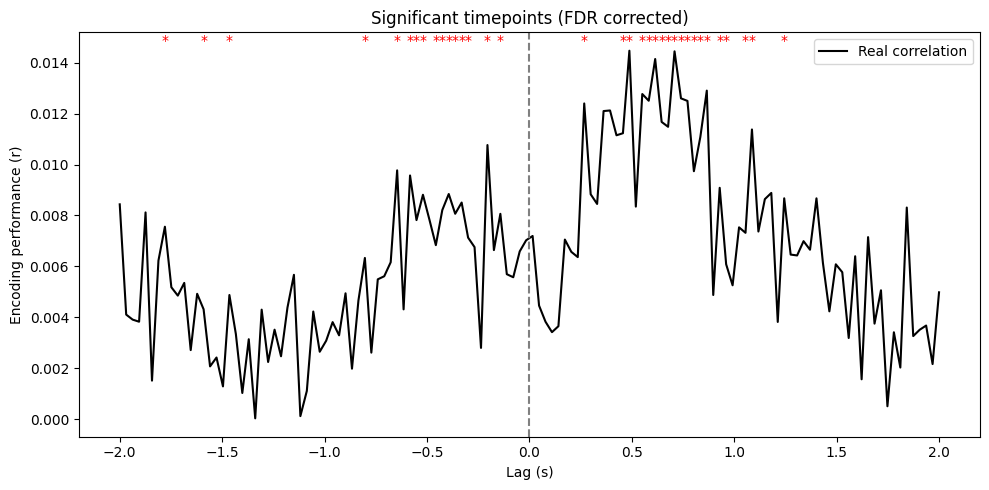

In [34]:
import matplotlib.pyplot as plt

lags = np.linspace(-pre_stimulus, tmax, correlations_time.shape[1])  # Assicurati sia coerente

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lags, real_corr_tp, color='black', label='Real correlation')
ax.axvline(0, color='gray', linestyle='--')
y_top = real_corr_tp.max() + 0.0001
# Aggiungi asterischi nei timepoint significativi
for t, sig in enumerate(significant_tp):
    if sig:
        ax.text(lags[t], y_top, '*', color='red', fontsize=10,
                ha='center', va='bottom')

ax.set_xlabel('Lag (s)')
ax.set_ylabel('Encoding performance (r)')
ax.set_title('Significant timepoints (FDR corrected)')
ax.legend()
plt.tight_layout()
plt.show()


In [36]:
correlations_channels.shape

(2052, 90)

In [290]:
import os

tosave_stats = f"/srv/nfs-data/sisko/matteoc/podcast/subj_data/sub_{subject}_text"
os.makedirs(tosave_stats, exist_ok=True)
np.save(os.path.join(tosave_stats, "significant_tp.npy"), significant_tp)
np.save(os.path.join(tosave_stats, "significant_ch.npy"), significant_ch)

## Evaluation pt2